# Flow Matching with Classifier-Free Guidance & Library Size Conditioning

**Updates:**
1. **Training:** Uses OT-Flow Matching (Gaussian Conditional Probability Path).
2. **Conditioning:** Conditions on both **Cell Type** and **Library Size**.
3. **Sampling:** Uses Euler ODE integration
4. **Decoding:** Rescales latents and decodes to counts using Negative Binomial.
5. **Plotting** Plotting UMAPs for comparison.

In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Optional, List, Tuple
from scvi.distributions import NegativeBinomial



from autoencoder_utils import NB_Autoencoder




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

yaaaas
Using device: cpu


In [38]:
# ---- Configuration & Paths ----
input_file_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_with_latent.h5ad"
vae_model_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_nb_autoencoder.pt" # Path to trained VAE
flow_model_save_path = "/dtu/blackhole/06/213542/paperdata/lib_size_flow_model.pt"

os.makedirs(os.path.dirname(flow_model_save_path), exist_ok=True)

# Hyperparameters
batch_size = 256
num_epochs = 4000
learning_rate = 5e-4
latent_dim = 50
drop_prob = 0.1   # Classifier-free guidance dropout probability
guidance_scale = 2.0
n_steps = 50      # Euler integration steps

In [39]:
# ---- Load Data ----
adata = ad.read_h5ad(input_file_path)
latent = adata.obsm["X_latent"]
latent_tensor = torch.tensor(latent, dtype=torch.float32, device=device)

# Library Sizes
if "total_counts" in adata.obs:
    lib_sizes = adata.obs["total_counts"].values
else:
    lib_sizes = np.array(adata.X.sum(1)).flatten()

log_lib_sizes = np.log1p(lib_sizes)
log_lib_tensor = torch.tensor(log_lib_sizes, dtype=torch.float32, device=device).unsqueeze(1)

# Stats for normalization and sampling
lib_min, lib_max = log_lib_tensor.min(), log_lib_tensor.max()
lib_mean, lib_std = log_lib_tensor.mean(), log_lib_tensor.std()

# Cell Types
cell_types = adata.obs["cell_type"].astype(str).values
unique_types, inverse_idx = np.unique(cell_types, return_inverse=True)
num_cell_types = len(unique_types)
cell_type_idx = torch.tensor(inverse_idx, dtype=torch.long, device=device)

print(f"Data Shape: {latent.shape}")
print(f"Library Size: Min={lib_min:.2f}, Max={lib_max:.2f}, Mean={lib_mean:.2f}")
print(f"Cell Types: {unique_types}")

Data Shape: (2110, 50)
Library Size: Min=6.49, Max=7.86, Mean=7.42
Cell Types: ['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'CD8 T cells' 'Dendritic cells'
 'FCGR3A+ Monocytes' 'Megakaryocytes' 'NK cells']


In [40]:
# ---- Flow Matching Classes (OT Path) ----

class EmpiricalDistribution(nn.Module):
    def __init__(self, data):
        super().__init__()
        self.register_buffer("data", data)
    def sample(self, n):
        idx = torch.randint(0, len(self.data), (n,), device=self.data.device)
        return self.data[idx]

class GaussianConditionalProbabilityPath:
    def __init__(self, p_data):
        self.p_data = p_data
    def sample_conditional_path(self, z, t):
        # Linear interpolation: t * z + (1-t) * noise
        # Note: Train_flow_cfg typically uses x1 (data) and x0 (noise)
        # Here we adapt to match the provided notebook logic:
        # Target is usually data, Source is noise.
        # path: x_t = t * x_1 + (1 - t) * x_0
        # vector field u_t = x_1 - x_0
        return t * z + (1 - t) * torch.randn_like(z)

    def conditional_vector_field(self, x_1, x_0):
        return x_1 - x_0

# ---- Neural Network (With Library Size) ----

class TimeEmbedder(nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.SiLU(),
            nn.Linear(embed_dim, embed_dim), nn.SiLU()
        )
        self.embed_dim = embed_dim
    def forward(self, t):
        # Sinusoidal embedding
        half_dim = self.embed_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
        return self.mlp(emb)

class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, time_embed_dim=64, lib_min=0, lib_max=10):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.z_proj = nn.Linear(latent_dim, hidden_dim) # Type conditioning
        self.time_embedder = TimeEmbedder(time_embed_dim)
        
        # Library size embedding
        self.lib_min = lib_min
        self.lib_max = lib_max
        self.l_proj = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        in_dim = hidden_dim * 3 + time_embed_dim
        self. net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, z, t, l):
        # x: current state, z: type condition, t: time, l: library size
        hx = self.x_proj(x)
        hz = self.z_proj(z)
        ht = self.time_embedder(t)
        
        # Library embedding (normalize first)
        l_norm = (l - self.lib_min) / (self.lib_max - self.lib_min)
        # Re-use time embedder logic for continuous scalar l
        hl_emb = self.time_embedder.forward(l_norm) 
        hl = self.l_proj(hl_emb)

        h = torch.cat([hx, hz, ht, hl], dim=-1)
        return self.net(h)

class CellTypeConditioner(nn.Module):
    def __init__(self, n_types, latent_dim):
        super().__init__()
        self.embed = nn.Embedding(n_types, latent_dim)
    def forward(self, idx):
        return self.embed(idx)

In [41]:
# ---- Initialize Models ----
vf_model = NeuralVectorField(latent_dim, lib_min=lib_min, lib_max=lib_max).to(device)
conditioner = CellTypeConditioner(num_cell_types, latent_dim).to(device)

optimizer = torch.optim.AdamW(list(vf_model.parameters()) + list(conditioner.parameters()), lr=learning_rate)

emp_dist = EmpiricalDistribution(latent_tensor)
path = GaussianConditionalProbabilityPath(emp_dist)

# Null token for classifier-free guidance
z_null = torch.zeros(1, latent_dim, device=device)

Training: 100%|██████████| 4000/4000 [01:08<00:00, 58.25it/s]


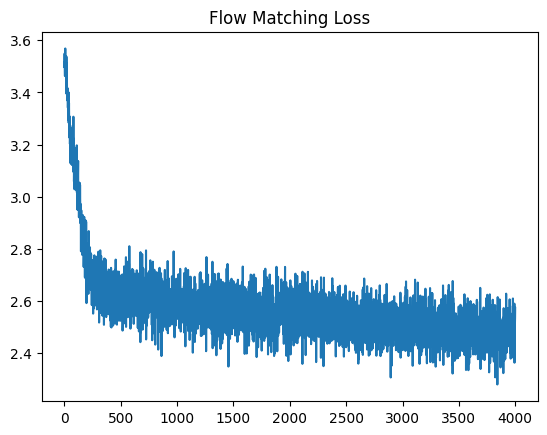

In [42]:
# ---- Training Loop (Flow Matching) ----
loss_history = []

vf_model.train()
conditioner.train()

for epoch in tqdm(range(num_epochs), desc="Training"):
    # 1. Sample Batch
    idx = torch.randint(0, len(latent_tensor), (batch_size,), device=device)
    x_1 = latent_tensor[idx] # Target data
    x_0 = torch.randn_like(x_1) # Source noise
    
    # Conditions
    batch_types = cell_type_idx[idx]
    batch_libs = log_lib_tensor[idx]

    # 2. Sample Time
    t = torch.rand(batch_size, 1, device=device)

    # 3. Compute Path (Interpolation)
    # x_t = t * x_1 + (1-t) * x_0
    x_t = t * x_1 + (1 - t) * x_0
    
    # 4. Compute Target Vector Field
    # u_t = x_1 - x_0
    u_target = x_1 - x_0

    # 5. Conditioning w/ Drop (CFG)
    z_emb = conditioner(batch_types)
    drop_mask = (torch.rand(batch_size, 1, device=device) < drop_prob)
    z_used = torch.where(drop_mask, z_null, z_emb)

    # 6. Prediction
    v_pred = vf_model(x_t, z_used, t, batch_libs)

    # 7. Loss
    loss = F.mse_loss(v_pred, u_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

plt.plot(loss_history)
plt.title("Flow Matching Loss")
plt.show()

In [43]:
# ---- Save Models ----
torch.save({
    'vf_state': vf_model.state_dict(),
    'cond_state': conditioner.state_dict()
}, flow_model_save_path)
print(f"Saved models to {flow_model_save_path}")

Saved models to /dtu/blackhole/06/213542/paperdata/lib_size_flow_model.pt


In [44]:
# ==================================================================================
# SAMPLING AND DECODING 
# ==================================================================================

# 1. Load VAE for Decoding
# We need the VAE to map latents -> gene counts
vae = NB_Autoencoder(num_features=adata.n_vars, latent_dim=latent_dim)
try:
    vae.load_state_dict(torch.load(vae_model_path, map_location=device))
    vae.to(device)
    vae.eval()
    print("VAE loaded successfully.")
except FileNotFoundError:
    print(f"Warning: VAE model not found at {vae_model_path}. Decoding will fail.")

# 2. Euler Integration Simulator 
class LearnedVectorFieldODE:
    def __init__(self, vf_model, conditioner, z_target, l_target, guidance_scale=2.0):
        self.vf = vf_model
        self.z = conditioner(z_target)
        self.l = l_target
        self.scale = guidance_scale
        self.z_null = torch.zeros_like(self.z)
    
    def drift(self, x, t):
        # Duplicate inputs for Cond and Uncond pass
        x_in = torch.cat([x, x], dim=0)
        t_in = torch.cat([t, t], dim=0)
        l_in = torch.cat([self.l, self.l], dim=0)
        z_in = torch.cat([self.z, self.z_null], dim=0)
        
        v_out = self.vf(x_in, z_in, t_in, l_in)
        v_cond, v_uncond = v_out.chunk(2, dim=0)
        
        # CFG Formula: v = v_uncond + s * (v_cond - v_uncond)
        return v_uncond + self.scale * (v_cond - v_uncond)

def generate_samples(target_type_idx, num_samples, fix_library_size=True):
    vf_model.eval()
    conditioner.eval()
    
    x = torch.randn(num_samples, latent_dim, device=device)
    # -------------------------------------------------------------------

    # B. Setup Conditions
    type_tensor = torch.full((num_samples,), target_type_idx, dtype=torch.long, device=device)

    # 2. Library Size
    if fix_library_size:
        l_val = lib_mean.item()
        l_tensor = torch.full((num_samples, 1), l_val, device=device)
    else:
        l_tensor = torch.normal(lib_mean.item(), lib_std.item(), (num_samples, 1), device=device)

    # C. ODE Integration (Euler)
    ode = LearnedVectorFieldODE(vf_model, conditioner, type_tensor, l_tensor, guidance_scale)
    dt = 1.0 / n_steps
    t = torch.zeros(num_samples, 1, device=device)
    
    print(f"Sampling {num_samples} cells (Type {target_type_idx})...")
    with torch.no_grad():
        for _ in range(n_steps):
            v = ode.drift(x, t)
            x = x + v * dt
            t = t + dt
            
    return x

"""['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'CD8 T cells' 'Dendritic cells'
 'FCGR3A+ Monocytes' 'Megakaryocytes' 'NK cells']"""

target_idx = 2
n_gen = 200
generated_latents = generate_samples(target_idx, n_gen)

# 4. Rescaling
# "generated_rescaled = (generated_tensor - generated_tensor.mean(dim=0)) / std_gen * std_orig + latent_tensor.mean(dim=0)"
std_orig = latent_tensor.std(dim=0)
mean_orig = latent_tensor.mean(dim=0)
std_gen = generated_latents.std(dim=0)
mean_gen = generated_latents.mean(dim=0)

generated_rescaled = (generated_latents - mean_gen) / std_gen * std_orig + mean_orig

# 5. Decoding with Fixed Library Size
target_lib_size = 1000 

print("Decoding to counts...")
with torch.no_grad():
    outputs = vae.decode(generated_rescaled, adata, target_lib_size)
    mu = outputs["mu"]
    theta = torch.exp(outputs["theta"])
    
    # Sample from Negative Binomial
    nb_dist = NegativeBinomial(mu=mu, theta=theta)
    X_gen_counts = nb_dist.sample().cpu().numpy()

print(f"Final Generated Counts Shape: {X_gen_counts.shape}")



# Optional: Save or Plot
# sc.AnnData(X=X_gen_counts).write(...)

VAE loaded successfully.
Sampling 200 cells (Type 2)...
Decoding to counts...
Final Generated Counts Shape: (200, 8573)


In [45]:
import anndata as ad
import os

# Paths
save_dir = "/dtu/blackhole/06/213542/paperdata/"
os.makedirs(save_dir, exist_ok=True)
counts_save_path = os.path.join(save_dir, "new_generated_pbmc3k_counts.h5ad")
latents_save_path = os.path.join(save_dir, "new_generated_pbmc3k_latents.pt")

# --- 1. Save Final Counts (for Scanpy/Evaluation) ---
# Create AnnData from the generated counts
adata_gen = ad.AnnData(X=X_gen_counts)

# Transfer gene names from the original data (if available)
if 'adata' in globals():
    adata_gen.var_names = adata.var_names

# Add metadata (e.g., which cell type was generated)
# Assuming 'target_type_idx' and 'unique_types' exist from previous cells
if 'unique_types' in globals() and 'target_type_idx' in globals():
    cell_type_name = unique_types[target_type_idx]
    adata_gen.obs['cell_type'] = cell_type_name
    
adata_gen.write(counts_save_path)
print(f"Saved generated counts to: {counts_save_path}")

Saved generated counts to: /dtu/blackhole/06/213542/paperdata/new_generated_pbmc3k_counts.h5ad



--- Starting Visualization Generation ---
Generating 250 cells per type for 8 types...
Decoding full dataset...
Running PCA and UMAP on merged dataset...


/zhome/df/7/213542/venv_1/lib/python3.11/site-packages/anndata/_core/anndata.py:1176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/zhome/df/7/213542/venv_1/lib/python3.11/site-packages/anndata/_core/anndata.py:1176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Figure saved to /dtu/blackhole/06/213542/paperdata/cfgen_results_figure_a2.png


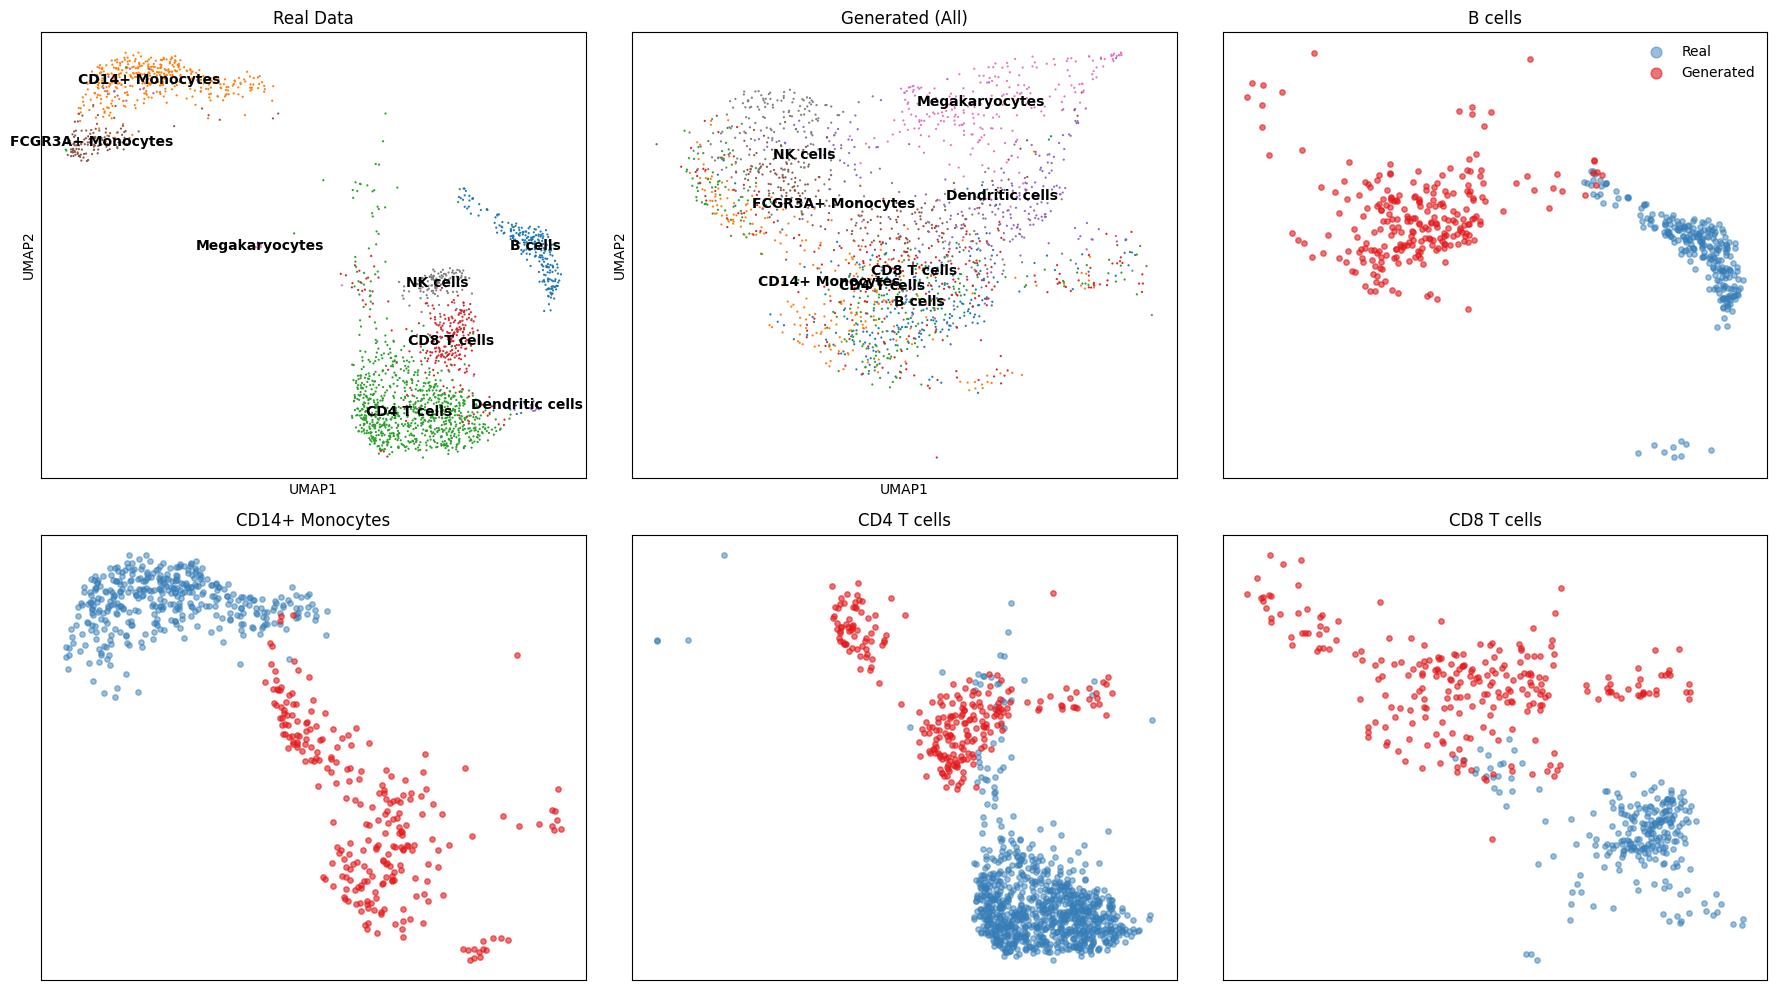

In [47]:
# ==================================================================================
# VISUALIZATION (Replicating Figure A2 from CFGen Paper)
# ==================================================================================
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print("\n--- Starting Visualization Generation ---")

def generate_full_dataset(n_per_type=200):
    """
    Generates samples for all cell types to create a full synthetic dataset.
    Re-implements sampling to ensure library sizes used in Flow matches Decoder.
    """
    vf_model.eval()
    conditioner.eval()
    
    all_latents = []
    all_lib_sizes = []
    all_types = []
    
    # 1. Generate Latents for each cell type
    print(f"Generating {n_per_type} cells per type for {len(unique_types)} types...")
    for idx, ct in enumerate(unique_types):
        # A. Setup Conditions
        type_tensor = torch.full((n_per_type,), idx, dtype=torch.long, device=device)
        
        # Sample Library Sizes from Real Distribution (Log-Normal approximation)
        l_tensor = torch.normal(lib_mean.item(), lib_std.item(), (n_per_type, 1), device=device)
        
        # B. Initial Noise
        x = torch.randn(n_per_type, latent_dim, device=device)
        
        # C. ODE Integration
        ode = LearnedVectorFieldODE(vf_model, conditioner, type_tensor, l_tensor, guidance_scale=10.0)
        dt = 1.0 / n_steps
        t = torch.zeros(n_per_type, 1, device=device)
        
        with torch.no_grad():
            for _ in range(n_steps):
                v = ode.drift(x, t)
                x = x + v * dt
                t = t + dt
        
        all_latents.append(x)
        all_lib_sizes.append(l_tensor)
        all_types.extend([ct] * n_per_type)
        
    # Concatenate all batches
    gen_latents_tensor = torch.cat(all_latents, dim=0)
    gen_libs_tensor = torch.cat(all_lib_sizes, dim=0)
    
    # 2. Rescaling
    mean_gen = gen_latents_tensor.mean(dim=0)
    std_gen = gen_latents_tensor.std(dim=0)
    mean_orig = latent_tensor.mean(dim=0)
    std_orig = latent_tensor.std(dim=0)
    
    gen_rescaled = (gen_latents_tensor - mean_gen) / std_gen * std_orig + mean_orig
    
    # 3. Decode to Counts
    lib_counts = torch.exp(gen_libs_tensor) - 1
    
    print("Decoding full dataset...")
    with torch.no_grad():
        # --- FIX IS HERE ---
        # We pass 'adata' as the second argument, and 'lib_counts' as the third.
        outputs = vae.decode(gen_rescaled, adata, lib_counts)
        # -------------------
        mu = outputs["mu"]
        theta = torch.exp(outputs["theta"])
        nb_dist = NegativeBinomial(mu=mu, theta=theta)
        X_counts = nb_dist.sample().cpu().numpy()
        
    return X_counts, np.array(all_types)

# --- 1. Generate Data ---
X_gen_all, types_gen_all = generate_full_dataset(n_per_type=250)

# --- 2. Prepare AnnData for Scanpy ---
# Real Data
adata_real = adata.copy()
adata_real.obs['dataset'] = 'Real'
# If adata.X is sparse, convert to dense for concatenation if needed, or handle sparse
if hasattr(adata_real.X, "toarray"):
    adata_real.X = adata_real.X.toarray()

# Generated Data
adata_gen = ad.AnnData(X=X_gen_all)
adata_gen.obs['cell_type'] = types_gen_all
adata_gen.obs['dataset'] = 'Generated'
adata_gen.var_names = adata_real.var_names

# Combine
adata_merged = ad.concat([adata_real, adata_gen], join='outer', label='batch', keys=['Real', 'Generated'])
adata_merged.obs['cell_type'] = adata_merged.obs['cell_type'].astype('category')

# --- 3. Preprocessing & Embedding ---
print("Running PCA and UMAP on merged dataset...")
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)
sc.pp.pca(adata_merged, n_comps=30)
sc.pp.neighbors(adata_merged, n_neighbors=15)
sc.tl.umap(adata_merged)

# --- 4. Plotting (Figure A2 Style) ---
# Define the specific cell types to highlight (matching paper if possible)
highlight_types = ['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells']

# Setup Figure
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 3, figure=fig)

# Helper for consistent plotting
def plot_umap_scatter(ax, adata_subset, color_col, title, palette=None, s=10):
    sc.pl.umap(adata_subset, color=color_col, ax=ax, show=False, 
               title=title, frameon=True, s=s, palette=palette, legend_loc='on data')
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

# Panel 1: Real Data (All Types)
ax1 = fig.add_subplot(gs[0, 0])
plot_umap_scatter(ax1, adata_merged[adata_merged.obs['dataset']=='Real'], 
                  'cell_type', 'Real Data')

# Panel 2: Generated Data (All Types / "Unconditional" view)
ax2 = fig.add_subplot(gs[0, 1])
plot_umap_scatter(ax2, adata_merged[adata_merged.obs['dataset']=='Generated'], 
                  'cell_type', 'Generated (All)')

# Helper for Overlap Plots (Real=Blue, Gen=Red)
def plot_overlap(ax, c_type):
    # Get coordinates
    mask_r = (adata_merged.obs['dataset'] == 'Real') & (adata_merged.obs['cell_type'] == c_type)
    mask_g = (adata_merged.obs['dataset'] == 'Generated') & (adata_merged.obs['cell_type'] == c_type)
    
    umap_r = adata_merged[mask_r].obsm['X_umap']
    umap_g = adata_merged[mask_g].obsm['X_umap']
    
    # Plot Real first (Blue)
    ax.scatter(umap_r[:, 0], umap_r[:, 1], s=15, c='#377eb8', alpha=0.5, label='Real')
    # Plot Gen on top (Red)
    ax.scatter(umap_g[:, 0], umap_g[:, 1], s=15, c='#e41a1c', alpha=0.6, label='Generated')
    
    ax.set_title(c_type)
    ax.set_xticks([])
    ax.set_yticks([])
    # Remove borders for clean look


# Panel 3-6: Overlaps for specific types
# Positions in grid: (0,2), (1,0), (1,1), (1,2)
locs = [(0, 2), (1, 0), (1, 1), (1, 2)]

for i, c_type in enumerate(highlight_types):
    if i >= len(locs): break
    ax = fig.add_subplot(gs[locs[i]])
    plot_overlap(ax, c_type)
    # Add legend only to the first overlap plot
    if i == 0:
        ax.legend(frameon=False, loc='upper right', markerscale=2)

plt.tight_layout()
save_plot_path = os.path.join(os.path.dirname(flow_model_save_path), "cfgen_results_figure_a2.png")
plt.savefig(save_plot_path, dpi=300)
print(f"Figure saved to {save_plot_path}")
plt.show()